In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [3]:
timeseries = df['Passengers'].values.astype('float32')
timeseries[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

In [4]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size

train = timeseries[:train_size]
test = timeseries[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 96
Test size: 48


In [5]:
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback)])
        y.append(dataset[i + lookback])
    X = np.array(X)
    y = np.array(y)

    return torch.tensor(X).float(), torch.tensor(y).float().view(-1, 1)

In [6]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


In [7]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [8]:
model = AirModel(hidden_size=50, num_layers=1)
test_input = torch.tensor([[[112.]]])  
test_output = model(test_input)
print("Test output:", test_output)

Test output: tensor([[[-0.1726]]], grad_fn=<ViewBackward0>)


In [9]:
train_ds = TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1))
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [10]:
model = AirModel(hidden_size=50, num_layers=1)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

losses = []

for epoch in range(2000):
    model.train()
    total_loss = 0

    for xb, yb in train_dl:
        yb = yb.squeeze(-1)
        output = model(xb)
        loss = loss_fn(output[:, -1], yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    losses.append(total_loss / len(train_dl))

    # Validation
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train.unsqueeze(-1))[:, -1]
            test_pred = model(X_test.unsqueeze(-1))[:, -1]

            train_rmse = torch.sqrt(loss_fn(train_pred, y_train))
            test_rmse = torch.sqrt(loss_fn(test_pred, y_test))

        print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 100: train RMSE 186.9985, test RMSE 381.6071
Epoch 200: train RMSE 155.6297, test RMSE 347.8706
Epoch 300: train RMSE 128.0898, test RMSE 316.8423
Epoch 400: train RMSE 104.8829, test RMSE 288.3661
Epoch 500: train RMSE 86.7567, test RMSE 262.7383
Epoch 600: train RMSE 70.2469, test RMSE 238.1996
Epoch 700: train RMSE 57.3245, test RMSE 215.2767
Epoch 800: train RMSE 47.2728, test RMSE 194.5554
Epoch 900: train RMSE 39.5717, test RMSE 176.0243
Epoch 1000: train RMSE 33.6710, test RMSE 160.0164
Epoch 1100: train RMSE 32.0509, test RMSE 146.0712
Epoch 1200: train RMSE 27.9363, test RMSE 135.2653
Epoch 1300: train RMSE 26.1701, test RMSE 126.6791
Epoch 1400: train RMSE 25.3668, test RMSE 120.1543
Epoch 1500: train RMSE 24.5488, test RMSE 114.5090
Epoch 1600: train RMSE 25.2245, test RMSE 109.7977
Epoch 1700: train RMSE 24.5494, test RMSE 107.4465
Epoch 1800: train RMSE 23.6145, test RMSE 103.5226
Epoch 1900: train RMSE 24.4562, test RMSE 101.7370
Epoch 2000: train RMSE 23.4376, test

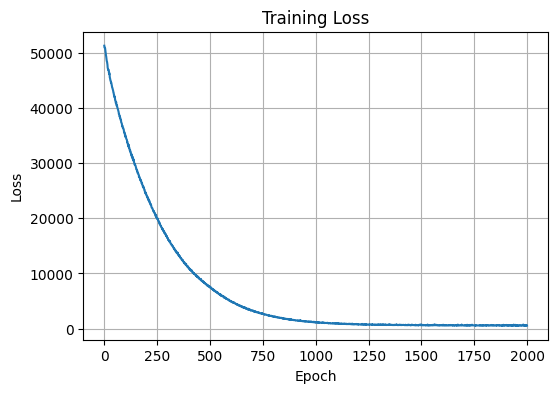

In [11]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

**The loss has stabilized, which indicates that the model successfully trained, but the RMSE on the test set remains high, suggesting poor generalization.**

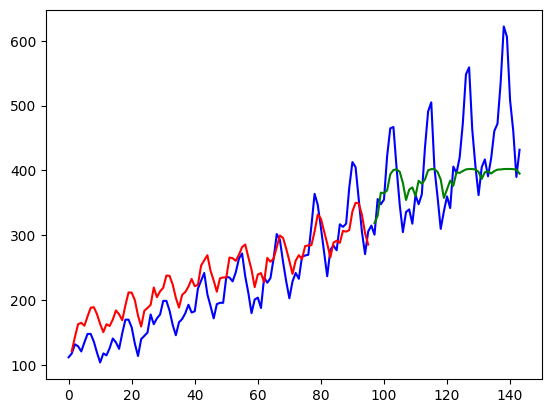

In [12]:
def plot_predicts(model):
  with torch.no_grad():
      # Offset the predictions for the training set
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Offset the predictions for the test set
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Visualization
  plt.plot(timeseries, c='b')  
  plt.plot(train_plot, c='r')  
  plt.plot(test_plot, c='g')  
  plt.show()

plot_predicts(model)

**The model learns the general upward trend but fails to capture the strong seasonal pattern of the series; as a result, predictions especially on the test set are overly smoothed and do not reflect real fluctuations.**

In [13]:
model_100 = AirModel(hidden_size=100, num_layers=1)
optimizer_100 = torch.optim.Adam(model_100.parameters())
loss_fn = nn.MSELoss()

losses_100 = []
for epoch in range(1000):
    model_100.train()
    total_loss = 0
    for xb, yb in train_dl:
        yb = yb.squeeze(-1)
        output = model_100(xb)
        loss = loss_fn(output[:, -1], yb)
        loss.backward()
        optimizer_100.step()
        optimizer_100.zero_grad()
        total_loss += loss.item()
    losses_100.append(total_loss / len(train_dl))
    
    # Validation
    if (epoch + 1) % 100 == 0:
        model_100.eval()
        with torch.no_grad():
            train_pred = model_100(X_train.unsqueeze(-1))[:, -1]
            test_pred = model_100(X_test.unsqueeze(-1))[:, -1]

            train_rmse = torch.sqrt(loss_fn(train_pred, y_train))
            test_rmse = torch.sqrt(loss_fn(test_pred, y_test))

        print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 100: train RMSE 147.8399, test RMSE 339.2733
Epoch 200: train RMSE 98.2639, test RMSE 279.4334
Epoch 300: train RMSE 68.8385, test RMSE 235.2474
Epoch 400: train RMSE 49.0955, test RMSE 198.4857
Epoch 500: train RMSE 37.0349, test RMSE 169.4072
Epoch 600: train RMSE 31.8349, test RMSE 147.2792
Epoch 700: train RMSE 26.8186, test RMSE 129.8591
Epoch 800: train RMSE 25.5565, test RMSE 118.2439
Epoch 900: train RMSE 25.2942, test RMSE 109.6040
Epoch 1000: train RMSE 23.7411, test RMSE 103.0167


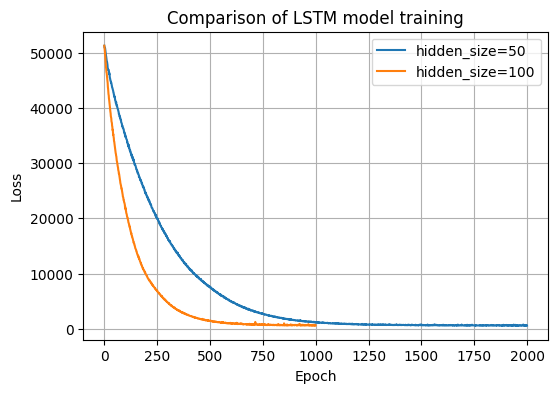

In [14]:
plt.figure(figsize=(6,4))
plt.plot(losses, label='hidden_size=50')
plt.plot(losses_100, label='hidden_size=100')
plt.title('Comparison of LSTM model training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

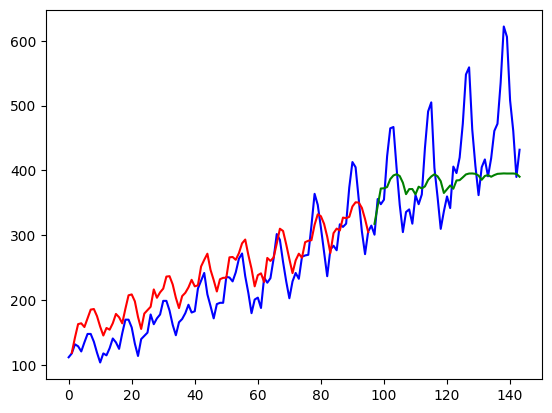

In [15]:
plot_predicts(model_100)

**The model captures the trend and partially captures the seasonal pattern, showing recognizable fluctuations on both training and test sets, but the predicted amplitudes are noticeably damped, and the model underestimates peak values.**